코드 생성

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
    
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [18]:
OV = 1
ms = 200 # message 한 bit 마다 20ms
INT = 10 # 적분시간 (ms)


# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4.
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [19]:
# 잡음의 전력 설정
noise_power = 6.31 # For -8dB. If -22dB, set noise_power to 158.49

# 잡음의 크기 설정
num_samples = 1023 * ms * OV
sigma = np.sqrt(noise_power)

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, sigma, num_samples) / (np.sqrt(2) * np.sqrt(OV))
imaginary_noise = np.random.normal(0, sigma, num_samples) / (np.sqrt(2) * np.sqrt(OV))

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

Data 생성

In [20]:
data = []
for i in range(ms//20):
    data.append((-1)**i)
RN = rand.randint(0,36)
t_code = codes[RN]
t_code = [chip/np.sqrt(OV) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []
for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)



Signal 생성

In [21]:
def generate_transmitted_signal(code_delay, doppler_freq, svNumber, code_freq, signal_length, OV = 1.023e6*OV):
    delayed_seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
    
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * doppler_freq * t / OV))
    # oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    signal = delayed_seq * oversampled_signal[:signal_length] + complex_noise
    return signal
    

Replica 신호 생성

In [22]:
def generate_replica_signal(code_delay, doppler_freq, code_freq, svNumber, signal_length = 1023*OV ,OV = 1.023e6*OV ):
    ca_code = np.array(codes[svNumber])
    ca_code = [chip for chip in ca_code for _ in range(int(OV//1.023e6))]
    delayed_code = np.roll(ca_code, code_delay)
    
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * (doppler_freq) * t / OV))
    # oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    replica =  delayed_code * oversampled_signal[:signal_length]
    replica = np.tile(replica, INT)
    return replica
    

Acquisition

In [23]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, signal_length, OV):
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    max_cor_lst = []
    signal_div = [signal[i:i+(1023*INT*OV)] for i in range(0,len(signal), 1023*INT*OV)]
    
    for i, doppler_freq in enumerate(doppler_freq_range):
        replica = generate_replica_signal(code_delay_range[0],doppler_freq,code_freq, svNumber)
        
        for j, code_delay in enumerate(code_delay_range):
            correlation = []
            for lst in signal_div:
                cor = np.abs(correlate(lst, replica, mode='valid'))
                correlation.append(np.max(cor))
            avg_cor = sum(correlation)/len(signal_div)
            
            if avg_cor > max_corr:
                max_corr = avg_cor
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
                max_cor_lst = correlation
                
            replica = np.roll(replica, OV)
    return max_corr, max_code_delay, max_doppler_freq, max_cor_lst
            

Acquisition 실행

In [24]:
# Parameters
code_delay_range = np.arange(0, 200*OV, OV)  # Range of code delay in chips
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
true_code_delay = rand.randint(0,200*OV)

true_doppler_freq = rand.randint(-5000,5000)
# true_doppler_freq = rand.sample(range(-5000, 5000, 500), 1)[0]
# true_doppler_freq = 0

received_signal = generate_transmitted_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, 1023*20*(ms//20)*OV)

# Perform acquisition
max_corr, estimated_code_delay, estimated_doppler_freq, est_cor_lst= acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,1023*20*(ms//20)*OV,OV)

print("-"*40)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV)
print("True doppler frequency:", true_doppler_freq)
print("Maximum correlation:", max_corr)
print("Estimated code delay:", estimated_code_delay/OV)
print("Estimated Doppler frequency:", estimated_doppler_freq)
print('Est_cor_lst :',est_cor_lst)

----------------------------------------
Target SV Number: 21
True Code Delay: 144.0
True doppler frequency: 2571
Maximum correlation: 684.1868102051069
Estimated code delay: 144.0
Estimated Doppler frequency: 2500.0
Est_cor_lst : [648.8324841690309, 318.96556990040096, 226.99231995407573, 703.8928283004902, 627.2004232681439, 989.5183536250115, 416.9644584379347, 800.3697674379923, 1023.2801127170763, 440.0749519557908, 870.1651543136755, 593.3928301479535, 837.552522809189, 428.64044939110175, 1016.2537702826709, 903.2316248638192, 1230.3109148113792, 550.1748450194052, 762.9290991694609, 294.99372352753574]


## 잠깐 plot해보기(그냥)

[ 0.69149547+1.54344003j  0.09525352-0.43891043j -0.9752205 +3.16290819j
 ... -1.22010799+0.03415551j -1.75060777-1.32635666j
  2.01058994-1.38313371j]


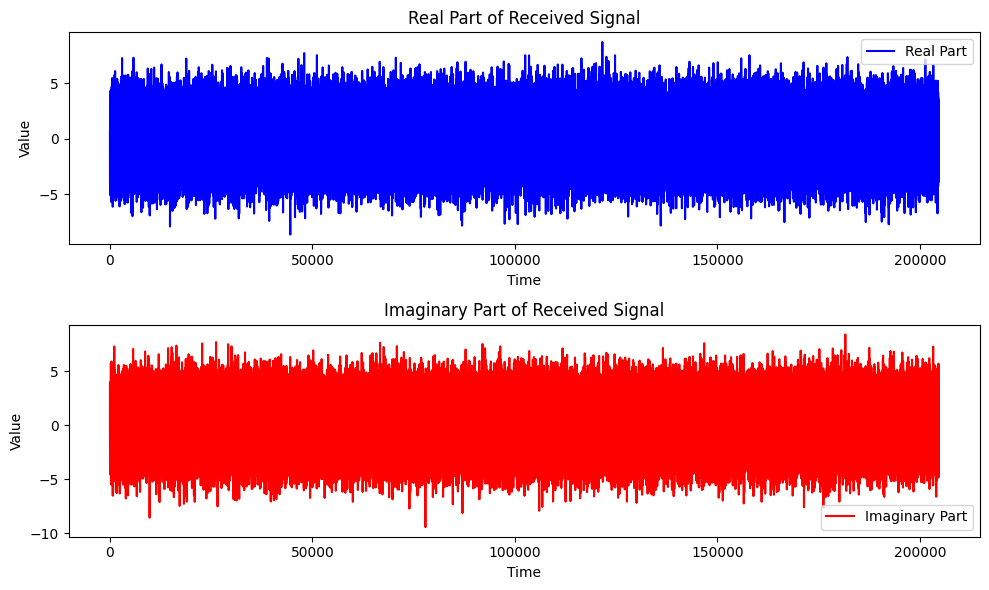

In [39]:
print(received_signal)
plt.figure(figsize=(10, 6))

# Plot the real part
plt.subplot(2, 1, 1)
plt.plot(np.real(received_signal[:]), label='Real Part', color='blue')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Real Part of Received Signal')
plt.legend()

# Plot the imaginary part
plt.subplot(2, 1, 2)
plt.plot(np.imag(received_signal[:]), label='Imaginary Part', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Imaginary Part of Received Signal')
plt.legend()

plt.tight_layout()
plt.show()

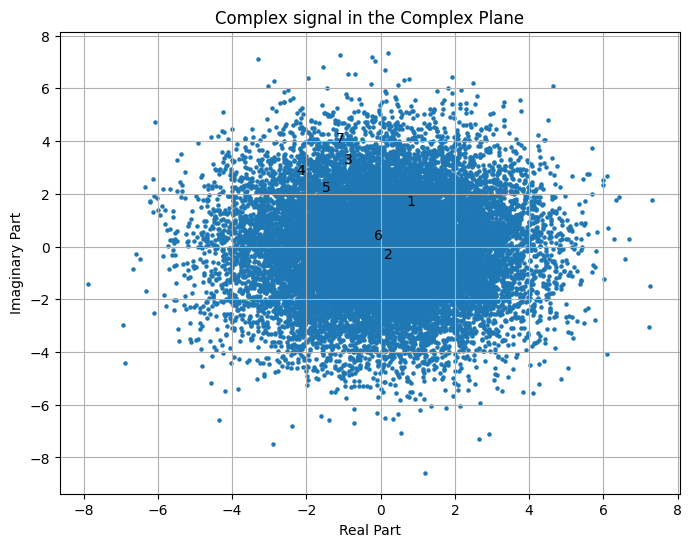

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(np.real(received_signal[:1023*20]), np.imag(received_signal[:1023*20]), s=5)

for i, txt in enumerate(range(1, 0 + 8)):
    plt.annotate(f'{txt}', (np.real(received_signal[i]), np.imag(received_signal[i])))
    
plt.title("Complex signal in the Complex Plane")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

## 병렬구조 만들기 (Demod, DLL 하기 전)

In [27]:
# 적분 범위 설정
LF = 5 # 100ms: 20ms안에서 corr 구한 것 -> 5개를 합쳐서 / 평균 구하기
        # (맥락상 이게 loop filter와 유사한 것 같음. 구간이 넓을 수록 추정은 빨라지지만, jitter가 심한 점, 좁을 수록 오래 걸리지만, jitter가 약한 점 생각해보면)
        # 물론 잡음 먹였을 때 얘기임
        
INT = 20 # 20ms동안 적분하도록 재설정(1bit씩, Demod를 위해서)
# 평균을 구하는 작업 하나, 각각 1bit씩은 따로 demod하는 작업 하나
# 옮겨다니는 건 어떻게 해야하지>>???>?????

신호를 I, Q로 쪼갠 뒤 각각을 계산해야함

In [36]:
# Extract real and imaginary parts separately
def spliter(signal):
    return np.real(signal), np.imag(signal)

real_part, imaginary_part = spliter(received_signal)

cur_code_delay = estimated_code_delay

E = generate_replica_signal(cur_code_delay - (OV // 2), estimated_doppler_freq, code_freq, svNumber)
P = generate_replica_signal(cur_code_delay, estimated_doppler_freq, code_freq, svNumber)
L = generate_replica_signal(cur_code_delay + (OV // 2), estimated_doppler_freq, code_freq, svNumber)

Real_E, Imag_E = spliter(E)
Real_P, Imag_P = spliter(P)
Real_L, Imag_L = spliter(L)

signal_div_Real = [real_part[i:i+(1023*INT*OV)] for i in range(0,len(real_part), 1023*INT*OV)]
signal_div_Imaginary = [imaginary_part[i:i+(1023*INT*OV)] for i in range(0,len(imaginary_part), 1023*INT*OV)]

def I_and_D(signal, replica):
    correlation = []
    for lst in signal:
        cor = correlate(lst, replica,mode='valid')
        correlation.append(np.max(cor))
    return list(correlation)

I_E = I_and_D(signal_div_Real, Real_E)
Q_E = I_and_D(signal_div_Imaginary, Imag_E)
I_P = I_and_D(signal_div_Real, Real_P)
Q_P = I_and_D(signal_div_Imaginary, Imag_P)
I_L = I_and_D(signal_div_Real, Real_L)
Q_L = I_and_D(signal_div_Imaginary, Imag_L)


Demodulation

In [37]:
Prompt = []
for i in range(len(I_P)):
    if I_P[i] > 0:
        Prompt.append(1)
    else:
        Prompt.append(-1)

print('data :', *data, sep = " ")
print('est :', *Prompt, sep = " ")


data : 1 -1 1 -1 1 -1 1 -1 1 -1
est : 1 -1 -1 -1 -1 -1 -1 -1 -1 1


결과 Plot

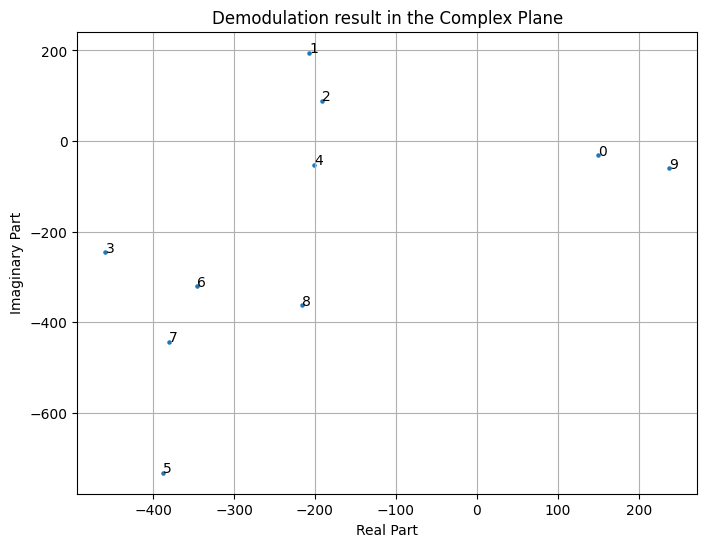

In [42]:
plt.figure(figsize=(8, 6))
plt.scatter(I_P, Q_P, s = 5)

for i in range(len(I_P)):
    plt.annotate(f'{i}', (I_P[i], Q_P[i]))
    
plt.title("Demodulation result in the Complex Plane")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

## Tracking loop test

fine frequency estimation (FLL)

In [31]:
#input 재정의: 
#kLargest = doppler주파수estimation한걸로 넣
#data = received_signal로 넣ㅇㅇ
#GPS_fs = 샘플링 주파수 넣ㅇㅇ(아마?)


def GetFineFrequency(data, kLargest, GPS_fs): # now passed in data class
    # Performs fine-frequency estimation. In this case, data will be a slice
    # of data (probably same length of data that was used in the circular
    # cross-correlation)


    # Perform DFT on each of the ms of data (5 total), at kLargest frequency.
    # Uses variables from medium-frequency, so if they change, may need to re-create below.
    X = []
    PhaseAngle = []
    numMSmf = 1 # num ms for medium-frequency estimation
    Nmf = int(np.ceil(numMSmf*0.001*GPS_fs))  # num of samples to use for medium-frequency estimation (and DFT)
    # Create sampled time array for DFT
    Ts = 1/GPS_fs
    nTs = np.linspace(0,Ts*(Nmf + 1),Nmf,endpoint=False)
    
    for i in range(0,5):
        X.append(sum(data[i*1023:(i+1)*1023]*np.exp(-2*np.pi*1j*kLargest*nTs)))
        PhaseAngle.append(np.arctan(np.imag(X[i])/np.real(X[i])))
        print("Magnitude: %f" %X[i])
        print("Phase Angle: %f" %PhaseAngle[i])

    # Get difference angles
    PhaseDiff = []
    for i in range(1,5):
        PhaseDiff.append(PhaseAngle[i]-PhaseAngle[i-1])
        print("Phase difference %d, is: %f"%((i-1),PhaseDiff[i-1]))


    PhaseThreshold = (2.3*np.pi)/5
    for (i,curPhaseDiff) in enumerate(PhaseDiff):
        if np.abs(curPhaseDiff) > PhaseThreshold:
            curPhaseDiff = PhaseDiff[i] - 2*np.pi
            if np.abs(curPhaseDiff) > PhaseThreshold:
                curPhaseDiff = PhaseDiff[i] + 2*np.pi
                if np.abs(curPhaseDiff) > (2.2*np.pi)/5:
                    curPhaseDiff = PhaseDiff[i] - np.pi
                    if np.abs(curPhaseDiff) > PhaseThreshold:
                        curPhaseDiff = PhaseDiff[i] - 3*np.pi
                        if np.abs(curPhaseDiff) > PhaseThreshold:
                            curPhaseDiff = PhaseDiff[i] + np.pi
        PhaseDiff[i] = curPhaseDiff
    fList = (np.array(PhaseDiff)/(2*np.pi*0.001))
    print(fList)
    print()
    print(np.mean(fList))

    FineFrequencyEst = (np.mean(fList)) #각 데이터 슬라이스에서 계산된 위상 차이에 대한 주파수 변화율
    return FineFrequencyEst


In [32]:
kLargest = estimated_doppler_freq
GPS_fs= code_freq
print(len(data))
FineFrequencyEst = GetFineFrequency(received_signal, kLargest, GPS_fs)

print()
print(FineFrequencyEst + estimated_doppler_freq)
print("frequency 추정 완료")



10
Magnitude: -10.051325
Phase Angle: -1.439352
Magnitude: 25.036660
Phase Angle: 1.343313
Magnitude: -26.850491
Phase Angle: 0.751026
Magnitude: 114.465284
Phase Angle: -0.744988
Magnitude: 60.081519
Phase Angle: -0.092570
Phase difference 0, is: 2.782665
Phase difference 1, is: -0.592286
Phase difference 2, is: -1.496014
Phase difference 3, is: 0.652418
[-57.12512625 -94.26529347 261.90190357 103.83554102]

53.586756219609924

2553.58675621961
frequency 추정 완료


C:\Users\minwoo\AppData\Local\Temp\ipykernel_24372\1995631675.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  print("Magnitude: %f" %X[i])
